<a href="https://colab.research.google.com/github/SURESHBEEKHANI/Advanced-LLM-Fine-Tuning/blob/main/llama3dpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune Llama3 using Direct Preference Optimization (DPO) 🤙

Welcome!

This is part 2 of our Llama3 finetuning series. Our last notebook was focused on using Supervised Finetuning (SFT) to finetune the Llama3-8B base model. In this one, we're going to take a different approach to finetuning and instead use Direct Preference Optimization. In our next notebook, we'll use ORPO - a novel technique that combines SFT and DPO into a single process!


A note about running Jupyter Notebooks: Press Shift + Enter to run a cell. A * in the left-hand cell box means the cell is running. A number means it has completed. If your Notebook is acting weird, you can interrupt a too-long process by interrupting the kernel (Kernel tab -> Interrupt Kernel) or even restarting the kernel (Kernel tab -> Restart Kernel). Note restarting the kernel will require you to run everything from the beginning.

Adapted from: [SURESH BEEKHANI ](https://www.linkedin.com/in/suresh-beekhani/)

## Introduction to finetuning using SFT and RLHF

At a high level, finetuning invovles taking a pre-trained LLM (like Llama3, Mistral7b, etc) and controlling its ouput for a certain task. This could be making a model respond in a company-specific manner, generating code in a specific format, or optimizing its performance in an academic field. Most guides online talk about finetuning using Supervised Finetuning (SFT). SFT involves retraining a model on input:output pairs essentially teaching a model what the correct output is given a specific type of input. SFT is extremely useful when you have a large amount of specific labeled data and when the tasks are well defined. Notice how there is no feedback loop in SFT. Once the dataset is created and the finetuning starts, the model does not receive any "feedback" on its performance. It simply learns the output based on the input provided.

In order to add feedback, we can use a concept called RLHF. RLHF extends the SFT process by having a separate trained "reward" model which approximates human feedback. This reward model provides scores to each LLM completion and serves as a proxy for a human evaluating an LLM response. This reward model optimizes a fine-tuned models output using the Promixal Policy Algorithm (PPO). PPO revolves around making smaller updates to a models policy in order to improve its performance based on preference. Hoever, PPO is still relatively unstable and difficult to reproduce. Along with that, training a separate reward model requires more data and is computationally expensive!

![RLHF](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*GiEF7F3n-1TlL7_HRJD_OA.png)

## How does DPO improve this

Direct Preference Optimization improves on a lot of the shortcomings of RLHF. Essentially, DPO treats a task as a classification problem. It uses 2 models: the trained model and a copy it called the reference model. During DPO traning, the goal is to make sure the trained model outputs higher probabilities for preferred answers and lower probabilities for rejected answers compared to the reference model. Because the LLM uses itself as a reward model, it is able to align itself without need for a reward model or extensive sampling and hyperparamter tuning. This results in a more stable and less computationally intensive process.

Note that under the hood, finetuning with DPO is still a 2 stage process: SFT then DPO!

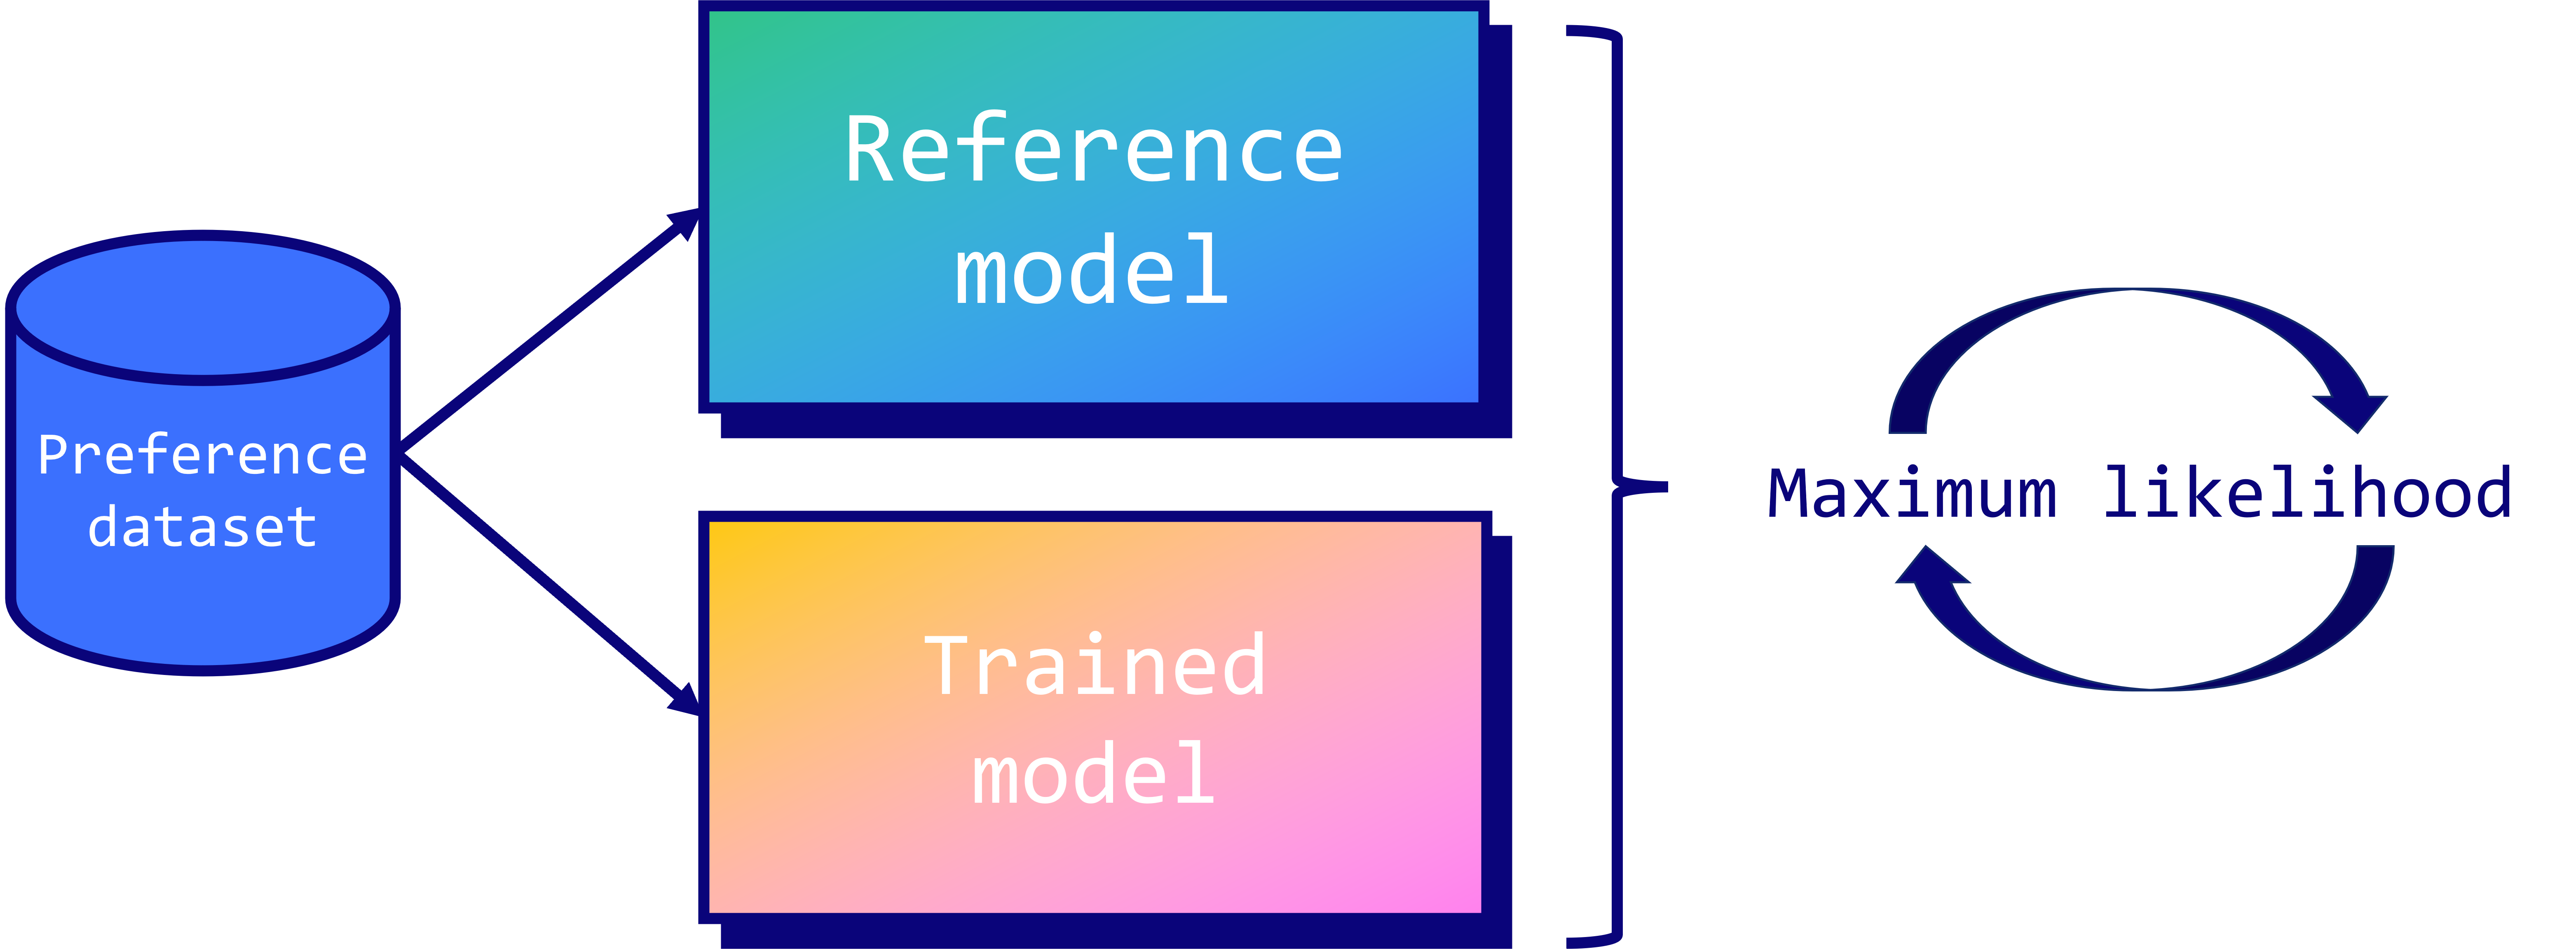

## Install dependencies

In [ ]:
!pip install datasets trl peft bitsandbytes wandb accelerate transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 67.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 64.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.3 MB/s eta 0:00

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import os
import gc
import torch
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    BitsAndBytesConfig
)
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from trl import DPOTrainer, setup_chat_format
import bitsandbytes as bnb

## Load the model and tokenizer

Note that we also load in a reference model. This is for completeness. If we did not provide one, the DPOTrainer will automatically create one for us

In [ ]:
base_model = "meta-llama/Meta-Llama-3-8B-Instruct"
new_model = "BrevDPOLlama-3-8B"

In [ ]:
# The bits and bytes config we use for quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
)
# Reference model
ref_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# LoRA configuration
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['k_proj', 'gate_proj', 'v_proj', 'up_proj', 'q_proj', 'o_proj', 'down_proj']
)

## Load and format dataset

Preference datasets are a little unique as I explained above. Let's take a look

In [ ]:
# Load dataset
dataset = load_dataset("Intel/orca_dpo_pairs")['train']

In [ ]:
# In this notebook we use a subset of 150 samples. In order to do a full tune, you can use around 1000 or the entire dataset
# The seed allows for reproducability. If you run this notebook exactly, you will use the same 150 samples as me
dataset = dataset.shuffle(seed=42).select(range(150))

In [ ]:
dataset

Dataset({
    features: ['system', 'question', 'chosen', 'rejected'],
    num_rows: 150
})

Preference datasets contain the original prompt along with `chosen` and `rejected` columns. These are our preferences. We want the model to respond in a certain way. Uncomment the cells below and tinker around to see why different answers were rejected or chosen!

In [ ]:
dataset[19]['question']

'WWE star invites Conor McGregor to join WWE\nConor McGregor turned the UFC world upside down in less than 140 characters Tuesday, cryptically tweeting that he has made the decision to "retire young."\n\nI have decided to retire young.Thanks for the cheese. Catch ya\'s later.\n\nNo one really knows what McGregor means. He may have just announced his retirement at the age of 27, or perhaps McGregor is simply sharing that he doesn\'t plan to fight well into his 30s. As one of the biggest stars in sports, and at the height of his earning potential, it would seem crazy for McGregor to actually retire - but he would certainly have lucrative options outside of the octagon.\n\nMcGregor\'s Irish compatriot Becky Lynch suggested on Twitter that the UFC superstar should make the jump to professional wrestling and join WWE.\n\nMcGregor wouldn\'t be the first MMA star to transition to WWE. "The World\'s Most Dangerous Man" Ken Shamrock is the best example of a success story. Shamrock came to WWE i

In [ ]:
dataset[19]['rejected']

" The article discusses the possibility of Conor McGregor, a UFC star, joining WWE. McGregor has announced his retirement from the UFC, and WWE star Becky Lynch has suggested that he should join WWE. The article explores the potential of McGregor joining WWE, including the possibility of him being a massive draw, but also notes that it would be challenging to integrate him into the WWE roster and storylines. The article also mentions other MMA stars who have transitioned to WWE, such as Ken Shamrock and Brock Lesnar. Additionally, the article suggests that McGregor's character and personality would be a major factor in any WWE storyline."

In [ ]:
dataset[19]['chosen']

'This article is about the speculation surrounding UFC star Conor McGregor\'s potential retirement from the sport after his cryptic tweet hinting at "retiring young." The article discusses the suggestion made by McGregor\'s Irish compatriot Becky Lynch that he should transition from UFC to professional wrestling, specifically WWE. The possibility of McGregor joining WWE is analysed, drawing comparisons with other MMA stars who have made the switch, such as Ken Shamrock, Dan Severn, Alberto Del Rio, Shinsuke Nakamura, and Brock Lesnar.\n\nThe article addresses various factors that would need to be considered, such as McGregor\'s professional wrestling training, potential character challenges, and the scope of his involvement in WWE storylines. It concludes by contemplating the idea of McGregor taking part in occasional high-profile WWE pay-per-view events, similar to Brock Lesnar\'s approach, rather than becoming a regular main eventer.'

Now we format the dataset in order to follow the Llama3 format using the extremely helpful chat templates created by chujiezheng

In [ ]:
!wget -L https://raw.githubusercontent.com/chujiezheng/chat_templates/main/chat_templates/llama-3-instruct.jinja

--2024-05-26 18:14:14--  https://raw.githubusercontent.com/chujiezheng/chat_templates/main/chat_templates/llama-3-instruct.jinja
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935 [text/plain]
Saving to: ‘llama-3-instruct.jinja.1’

llama-3-instruct.ji 100%[===================>]     935  --.-KB/s    in 0s      

2024-05-26 18:14:15 (27.2 MB/s) - ‘llama-3-instruct.jinja.1’ saved [935/935]



In [ ]:
chat_template = open('llama-3-instruct.jinja').read()
chat_template = chat_template.replace('    ', '').replace('\n', '')
tokenizer.chat_template = chat_template

In [ ]:
def dataset_format(example):
    # Format system
    if len(example['system']) > 0:
        message = {"role": "system", "content": example['system']}
        system = tokenizer.apply_chat_template([message], tokenize=False)
    else:
        system = ""
    # Format instruction
    message = {"role": "user", "content": example['question']}
    prompt = tokenizer.apply_chat_template([message], tokenize=False, add_generation_prompt=True)
    # Format chosen answer
    chosen = example['chosen'] + "<|eot_id|>\n"
    # Format rejected answer
    rejected = example['rejected'] + "<|eot_id|>\n"
    return {
        "prompt": system + prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

In [ ]:
original_columns = dataset.column_names
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

dataset = dataset.map(
    dataset_format,
    remove_columns=original_columns,
    num_proc= os.cpu_count(),
)

Map (num_proc=12):   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
# notice the specific llama3 tags like <|eot_id|> which show that the chat template formatting worked
dataset[19]

{'chosen': 'This article is about the speculation surrounding UFC star Conor McGregor\'s potential retirement from the sport after his cryptic tweet hinting at "retiring young." The article discusses the suggestion made by McGregor\'s Irish compatriot Becky Lynch that he should transition from UFC to professional wrestling, specifically WWE. The possibility of McGregor joining WWE is analysed, drawing comparisons with other MMA stars who have made the switch, such as Ken Shamrock, Dan Severn, Alberto Del Rio, Shinsuke Nakamura, and Brock Lesnar.\n\nThe article addresses various factors that would need to be considered, such as McGregor\'s professional wrestling training, potential character challenges, and the scope of his involvement in WWE storylines. It concludes by contemplating the idea of McGregor taking part in occasional high-profile WWE pay-per-view events, similar to Brock Lesnar\'s approach, rather than becoming a regular main eventer.<|eot_id|>\n',
 'rejected': " The articl

## Create the DPO trainer

In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: ishandhanani (brevdev). Use `wandb login --relogin` to force relogin


True

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    max_steps=50, #tweak this to change # of steps in the training run
    save_strategy="no",
    logging_steps=1,
    output_dir=new_model,
    optim="paged_adamw_32bit",
    warmup_steps=10,
    bf16=True,
    report_to="wandb",
)

In [ ]:
dpo_trainer = DPOTrainer(
    model,
    ref_model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer,
    peft_config=peft_config,
    beta=0.1,
    max_prompt_length=512,
    max_length=1024,
    force_use_ref_model=True
)

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/trl/trainer/dpo_trainer.py:332: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(
Parameter 'function'=<bound method DPOTrainer.tokenize_row of <trl.trainer.dpo_trainer.DPOTrainer object at 0x7fe2b2c6afb0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# Fine-tune model with DPO
dpo_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
1,0.685900
2,0.717800
3,0.692400
4,0.680900
5,0.682300
6,0.615300
7,0.585400
8,0.512000
9,0.508400
10,0.508200


TrainOutput(global_step=50, training_loss=0.16459717149700737, metrics={'train_runtime': 303.6254, 'train_samples_per_second': 1.317, 'train_steps_per_second': 0.165, 'total_flos': 0.0, 'train_loss': 0.16459717149700737, 'epoch': 2.6666666666666665})

## Analyze training run

Lets take a deeper look at our training run. Specifically, the `train/rewards/chosen, train/rewards/rejected`. This plot corresponds to the mean difference between the log probabilities output by the trained and reference model. Notice that over time they diverge which shows that the model is learning the preferred answer type.

Additionally, take a look at the `train/reward/accuracies` graph which shows frequency of choosing preferred answer. This could be a good sign but could also mean that the difference between the chosen and rejected answer in our dataset is too obvious.

![W&B Chart 5_14_2024, 2_49_00 PM.png](attachment:da58a367-db11-4539-9430-f3dd7a31da45.png)

![W&B Chart 5_14_2024, 2_52_24 PM.png](attachment:1dfb0fec-f64f-4381-8f69-5e8e8608e8e7.png)

## Save and test model

In [ ]:
dpo_trainer.model.save_pretrained("final_ckpt")

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
tokenizer.save_pretrained("final_ckpt")

('final_ckpt/tokenizer_config.json',
 'final_ckpt/special_tokens_map.json',
 'final_ckpt/tokenizer.json')

In [ ]:
# Flush memory
del dpo_trainer, model, ref_model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Reload model in FP16 (instead of NF4)
base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    return_dict=True,
    torch_dtype=torch.float16,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
tokenizer.chat_template = chat_template

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Merge base model with the adapter
model = PeftModel.from_pretrained(base_model, "final_ckpt")
model = model.merge_and_unload()

# Save model and tokenizer
model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)

('BrevDPOLlama-3-8B/tokenizer_config.json',
 'BrevDPOLlama-3-8B/special_tokens_map.json',
 'BrevDPOLlama-3-8B/tokenizer.json')

In [ ]:
# Create pipeline
pipeline = transformers.pipeline(
    "text-generation",
    model=new_model,
    tokenizer=tokenizer
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Format prompt
message = [
    {"role": "system", "content": "You are a helpful assistant chatbot that provides concise answers."},
    {"role": "user", "content": "What are GPUs and why would I use them for machine learning tasks?"}
]
tokenizer = AutoTokenizer.from_pretrained(new_model)
prompt = tokenizer.apply_chat_template(message, add_generation_prompt=True, tokenize=False)

# Generate text
sequences = pipeline(
    prompt,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    num_return_sequences=1,
    max_length=200,
)
print(sequences[0]['generated_text'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant chatbot that provides concise answers.<|eot_id|><|start_header_id|>user<|end_header_id|>

What are GPUs and why would I use them for machine learning tasks?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

GPUs (Graphics Processing Units) are specialized computer chips designed for parallel processing, making them ideal for accelerating tasks that require numerous calculations, such as:

1. Graphics rendering
2. Scientific simulations
3. Data processing and machine learning

For machine learning tasks, GPUs offer significant benefits:

1. Faster training times: GPUs can process vast amounts of data in parallel, reducing training times by 10-100x or more.
2. Increased model complexity: GPUs enable you to train more complex models with larger datasets, leading to better accuracy and performance.
3. Scalability: GPUs can be easily scaled up or down depending on the task's requirements, making t